In [ ]:
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Uncomment if you aare using colab. Now we connect the colab notebook to our drive to access the data.
from google.colab import drive
drive.mount('/content/gdrive')
# Run the cell and follow the instructions

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
print(tf.__version__)

2.15.0


In [ ]:

DIRECTORY = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app'

SUMMARY_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundLabels.csv'

HEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesHealthy.csv")
UNHEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesUnhealthy.csv")

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'

In [ ]:
# DIRECTORY = 'NLP_app'

# SUMMARY_PATH = 'NLP_app/MutualFundSummary'
# SUMMARY_LABELS_PATH = 'NLP_app/MutualFundLabels.csv'

# HEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesHealthy.csv")
# UNHEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesUnhealthy.csv")

# glove_word2vec = 'glove.6B.50d.txt'
# our_word2vec = 'word2vec_perso.txt'

In [ ]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename),'a' , encoding='utf-8') as f :
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename), encoding='utf8') as f:
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

In [ ]:
df_MutualFundLabels = pd.read_csv(SUMMARY_LABELS_PATH)
df_MutualFundLabels

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration
0,0000051931-18-000151,American Funds College 2018 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
1,0000051931-18-000151,American Funds College 2021 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
2,0000051931-18-000151,American Funds College 2024 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
3,0000051931-18-000151,American Funds College 2027 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
4,0000051931-18-000151,American Funds College 2030 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
...,...,...,...,...,...,...,...
462,0001710607-18-000172,American Century Diversified Corporate Bond ETF,NaN,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified
463,0001710607-18-000172,American Century Diversified Municipal Bond ETF,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified
464,0001710607-18-000172,American Century Quality Diversified Internati...,NaN,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified
465,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,NaN,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified


# 1. Split the data into training, validation, and testing.


## Preprocessing

In [ ]:
nan_counts = df_MutualFundLabels.isna().sum()
print("Missing values per column:")
print(nan_counts)

# Distribution and imbalance check for categorical data
print("\nDistribution of 'Investment Strategy':")
print(df_MutualFundLabels['Ivestment Strategy'].value_counts())

print("\nDistribution of 'Performance fee?':")
print(df_MutualFundLabels['Performance fee?'].value_counts())

print("\nDistribution of 'Leverage?':")
print(df_MutualFundLabels['Leverage?'].value_counts())

print("\nDistribution of 'Portfolio composition?':")
print(df_MutualFundLabels['Portfolio composition'].value_counts())

print("\nDistribution of 'Concentration?':")
print(df_MutualFundLabels[' Concentration'].value_counts())

Missing values per column:
id                         0
fund_name                  0
Performance fee?         447
Ivestment Strategy         0
Leverage?                  0
Portfolio composition      0
 Concentration             0
dtype: int64

Distribution of 'Investment Strategy':
Ivestment Strategy
Equity Long Only (Low Risk)          248
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Long Short Funds (High Risk)           4
Commodities Fund (Low Risk)            1
Name: count, dtype: int64

Distribution of 'Performance fee?':
Performance fee?
Some performance Fees    20
Name: count, dtype: int64

Distribution of 'Leverage?':
Leverage?
No     275
Yes    192
Name: count, dtype: int64

Distribution of 'Portfolio composition?':
Portfolio composition
Investment grade securities                            183
Listed Equities                                        177
Sub-investment grade securities or emerging markets    107
Name: count, dtype: int64

Di

In [ ]:
y = df_MutualFundLabels['Ivestment Strategy']
X = df_MutualFundLabels.drop(columns ="Ivestment Strategy")

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temp into validation (2/3 of temp, which is 20% of the total data) and test (1/3 of temp, 10% of the total data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

X_train

,id,fund_name,Performance fee?,Leverage?,Portfolio composition,Concentration
26,0000051931-18-000465,Managed Risk Growth Fund,NaN,Yes,Investment grade securities,Diversified
7,0000051931-18-000151,American Funds College Enrollment Fund,NaN,Yes,Investment grade securities,Diversified
426,0001591556-18-000016,Dreyfus Global Emerging Markets Fund,NaN,Yes,Sub-investment grade securities or emerging ma...,Diversified
108,0000940394-18-000852,Eaton Vance Growth Fund,NaN,No,Listed Equities,Diversified
423,0001580642-18-006021,Anchor Tactical Equity Strategies Fund,NaN,Yes,Investment grade securities,Diversified
...,...,...,...,...,...,...
106,0000940394-18-000852,Eaton Vance Dividend Builder Fund,NaN,Yes,Listed Equities,Diversified
270,0001193125-18-227777,Ivy Global Equity Income Fund,NaN,No,Listed Equities,Diversified
348,0001379491-18-003799,Franklin FTSE Australia ETF,NaN,No,Listed Equities,Concentrated by issuer / sector / jurisdiction
435,0001683863-18-000108,S&P 500 Index Fund,NaN,No,Listed Equities,Diversified


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(326, 6)
(94, 6)
(47, 6)


# 2. Following the NLP application in class,use the skip-gram model to build a word embedding dictionary from the mutual fund summaries in the training set.

In [ ]:
fund_names, summaries = get_data(SUMMARY_PATH)
fund_names_in_x_train = X_train['fund_name'].tolist()

print(fund_names_in_x_train)
# Filter summaries where the fund name is in X_train
selected_summaries = [summary for fund_name, summary in zip(fund_names, summaries) if fund_name in fund_names_in_x_train]

print(len(fund_names_in_x_train))
print(len(selected_summaries))

['Managed Risk Growth Fund', 'American Funds College Enrollment Fund', 'Dreyfus Global Emerging Markets Fund', 'Eaton Vance Growth Fund', 'Anchor Tactical Equity Strategies Fund', 'Cornerstone Moderately Aggressive Fund', 'Eaton Vance Arizona Municipal Income Fund', 'Eaton Vance TABS 10-to-20 Year Laddered Municipal Bond Fund', 'Fidelity Simplicity RMD 2015 Fund', 'MainStay VP Janus Henderson Balanced Portfolio', 'Columbia Overseas Value Fund', 'Fidelity Advisor Utilities Fund', 'Franklin FTSE Hong Kong ETF', 'Fidelity International Discovery Fund', 'PIMCO California Municipal Bond Fund', 'Janus Henderson Mid Cap Value Portfolio', 'Swan Defined Risk Emerging Markets Fund', 'MFS Tennessee Municipal Bond Fund', 'Fidelity Advisor Health Care Fund', 'Columbia Small Cap Value Fund II', 'Janus Henderson Research Fund', 'Franklin FTSE Europe ETF', 'Columbia Small Cap Index Fund', 'Variable Portfolio - Oppenheimer International Growth Fund', 'Eaton Vance Large-Cap Value Fund', 'PIMCO REALPATH 

In [ ]:
# clean and tokenize the text -> we don't want to lemmatize
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

In [ ]:
stop_words = set(stopwords.words('english'))
text_words = np.concatenate([tokenizer(summary) for summary in selected_summaries])

In [ ]:
print(text_words[:20])

['fund' 'summary' 'investment' 'objective' 'fund' 'seeks' 'long-term'
 'capital' 'growth' 'fees' 'expenses' 'following' 'table' 'describes'
 'fees' 'expenses' 'may' 'pay' 'buy' 'hold']


In [ ]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [ ]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [ ]:
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [ ]:
print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 2917


In [ ]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [ ]:
print(data[:20])

[1, 321, 3, 125, 1, 233, 272, 70, 94, 13, 9, 165, 53, 359, 13, 9, 2, 66, 179, 182]


In [ ]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

### Train the skip-gram model

In [ ]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors
    encoder = Model(input_word, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

# We create the model
encoder, autoencoder = creat_word2vec_model()

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2917)]            0         
                                                                 
 dense (Dense)               (None, 50)                145900    
                                                                 
 dense_1 (Dense)             (None, 2917)              148767    
                                                                 
Total params: 294667 (1.12 MB)
Trainable params: 294667 (1.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Finally we can train the model by feeding it with our batch generator !
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

<ipython-input-23-872bc948d3d9>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)


Epoch 1/2
4588/4588 [==============================] - 138s 30ms/step - loss: 0.0191
Epoch 2/2
4588/4588 [==============================] - 115s 25ms/step - loss: 0.0025


In [ ]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

save_word2vec(our_word2vec) # if rerun

1/1 [==============================] - 0s 23ms/step


# 3. Design a strategy to build knowledge bases associated to aforementioned three main mutual fund types.

Here we use clustering to build knowledge bases.

In [ ]:
key_words = [
    'Investment', 'Objective', 'Fees', 'Expenses', 'Shareholder', 'Annual',
    'Operating', 'Fee', 'Waiver', 'Expense', 'Reimbursement', 'Portfolio',
    'Turnover', 'Principal', 'Strategies', 'Equity', 'Securities',
    'High-Yield', 'Debt', 'Dynamic', 'Asset', 'Allocation', 'Derivatives',
    'Currency', 'Risk', 'Credit', 'Interest', 'Rate', 'Inflation', 'Foreign',
    'Non-U.S.', 'Emerging', 'Market', 'Derivatives', 'Short', 'Sale',
    'Leverage', 'Market', 'Liquidity', 'Management', 'Performance',
    'Information', 'Average', 'Annual', 'Total', 'Returns', 'Investment',
    'Adviser', 'Portfolio', 'Managers', 'Additional', 'Information'
]

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

class CustomWord2Vec:
    def __init__(self, word2vec_vec):
        # Initialize with your pre-loaded vectors
        self.vectors = word2vec_vec

    def most_similar(self, word, top_n=5):
        if word not in self.vectors:
            return []
        similarities = {}
        word_vec = self.vectors[word].reshape(1, -1)
        for other_word, vec in self.vectors.items():
            if other_word != word:
                sim = cosine_similarity(word_vec, vec.reshape(1, -1))
                similarities[other_word] = sim[0][0]
        sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        return sorted_similarities[:top_n]

# Instantiate the model
word2vec_model = CustomWord2Vec(word2vec)

In [ ]:
knowledge_base = {keyword: word2vec_model.most_similar(keyword, top_n=5) for keyword in key_words}
knowledge_base

{'Investment': [],
 'Objective': [],
 'Fees': [],
 'Expenses': [],
 'Shareholder': [],
 'Annual': [],
 'Operating': [],
 'Fee': [],
 'Waiver': [],
 'Expense': [],
 'Reimbursement': [],
 'Portfolio': [],
 'Turnover': [],
 'Principal': [],
 'Strategies': [],
 'Equity': [],
 'Securities': [],
 'High-Yield': [],
 'Debt': [],
 'Dynamic': [],
 'Asset': [],
 'Allocation': [],
 'Derivatives': [],
 'Currency': [],
 'Risk': [],
 'Credit': [],
 'Interest': [],
 'Rate': [],
 'Inflation': [],
 'Foreign': [],
 'Non-U.S.': [],
 'Emerging': [],
 'Market': [],
 'Short': [],
 'Sale': [],
 'Leverage': [],
 'Liquidity': [],
 'Management': [],
 'Performance': [],
 'Information': [],
 'Average': [],
 'Total': [],
 'Returns': [],
 'Adviser': [],
 'Managers': [],
 'Additional': []}

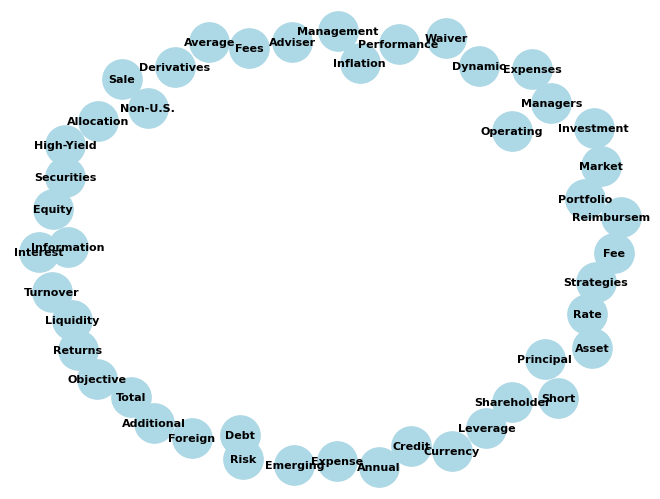

In [ ]:
import networkx as nx

G = nx.DiGraph()

for keyword, related_terms in knowledge_base.items():
    G.add_node(keyword, type='keyword')
    for term, similarity in related_terms:
        G.add_node(term, type='related_term')
        G.add_edge(keyword, term, weight=similarity)

# Visualization
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, k=0.5)  # k regulates the distance between nodes
nx.draw(G, pos, with_labels=True, node_size=800, node_color='lightblue', edge_color='gray', font_size=8, font_weight='bold')
plt.show()

In [ ]:
knowledge_base = list(knowledge_base)

# 4. Measure distance of each summary to each knowledge base. Design a classification algorithm to predict the investment strategy of each fund.

## Measure distance

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine all texts to ensure the vocabulary is the same for both sets
all_texts = selected_summaries + knowledge_base

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Extract TF-IDF vectors for summaries and KB entries
tfidf_summaries = tfidf_matrix[:len(selected_summaries)]
tfidf_kb_entries = tfidf_matrix[len(selected_summaries):]

# Calculate cosine similarity between each summary and each KB entry
similarity_matrix = cosine_similarity(tfidf_summaries, tfidf_kb_entries)

# Print out similarity scores
for i, summary in enumerate(selected_summaries):
    for j, entry in enumerate(knowledge_base):
        print(f"Similarity between Summary {i+1} and KB Entry {j+1}: {similarity_matrix[i][j]:.2f}")


Streaming output truncated to the last 5000 lines.
Similarity between Summary 218 and KB Entry 15: 0.00
Similarity between Summary 218 and KB Entry 16: 0.02
Similarity between Summary 218 and KB Entry 17: 0.07
Similarity between Summary 218 and KB Entry 18: 0.00
Similarity between Summary 218 and KB Entry 19: 0.02
Similarity between Summary 218 and KB Entry 20: 0.00
Similarity between Summary 218 and KB Entry 21: 0.02
Similarity between Summary 218 and KB Entry 22: 0.00
Similarity between Summary 218 and KB Entry 23: 0.03
Similarity between Summary 218 and KB Entry 24: 0.01
Similarity between Summary 218 and KB Entry 25: 0.08
Similarity between Summary 218 and KB Entry 26: 0.01
Similarity between Summary 218 and KB Entry 27: 0.04
Similarity between Summary 218 and KB Entry 28: 0.01
Similarity between Summary 218 and KB Entry 29: 0.00
Similarity between Summary 218 and KB Entry 30: 0.07
Similarity between Summary 218 and KB Entry 31: 0.01
Similarity between Summary 218 and KB Entry 32: 

In [ ]:
similarity_matrix.shape

(326, 46)

In [ ]:
similarity_matrix = similarity_matrix.T
similarity_matrix.shape

(46, 326)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'similarity_matrix' is already calculated as shown previously
kb_entries_labels = [f"{knowledge_base[i]}" for i in range(10)]
summaries_labels = [f"Summary {j+1}" for j in range(10)]

import plotly.graph_objects as go

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
                   z=similarity_matrix[:10][:10],
                   x=summaries_labels,
                   y=kb_entries_labels,
                   hoverongaps = False,
                   colorscale = 'Viridis'))

fig.update_layout(
    title='Cosine Similarity between Summaries and Knowledge Base Entries',
    xaxis_nticks=36,
    yaxis_nticks=36,
    xaxis_title="Summaries",
    yaxis_title="Knowledge Base Entries",
    font=dict(
        size=18  # Adjust the font size here
    )
)

fig.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'similarity_matrix' is already calculated as shown previously
kb_entries_labels = [f"{knowledge_base[i]}" for i in range(10, 20)]
summaries_labels = [f"Summary {j+1}" for j in range(10)]

import plotly.graph_objects as go

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
                   z=similarity_matrix[10:20][:10],
                   x=summaries_labels,
                   y=kb_entries_labels,
                   hoverongaps = False,
                   colorscale = 'Viridis'))

fig.update_layout(
    title='Cosine Similarity between Summaries and Knowledge Base Entries',
    xaxis_nticks=36,
    yaxis_nticks=36,
    xaxis_title="Summaries",
    yaxis_title="Knowledge Base Entries",
    font=dict(
        size=18  # Adjust the font size here
    )
)

fig.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'similarity_matrix' is already calculated as shown previously
kb_entries_labels = [f"{knowledge_base[i]}" for i in range(20, 30)]
summaries_labels = [f"Summary {j+1}" for j in range(10)]

import plotly.graph_objects as go

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
                   z=similarity_matrix[20:30][:10],
                   x=summaries_labels,
                   y=kb_entries_labels,
                   hoverongaps = False,
                   colorscale = 'Viridis'))

fig.update_layout(
    title='Cosine Similarity between Summaries and Knowledge Base Entries',
    xaxis_nticks=36,
    yaxis_nticks=36,
    xaxis_title="Summaries",
    yaxis_title="Knowledge Base Entries",
    font=dict(
        size=18  # Adjust the font size here
    )
)

fig.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'similarity_matrix' is already calculated as shown previously
kb_entries_labels = [f"{knowledge_base[i]}" for i in range(30, 40)]
summaries_labels = [f"Summary {j+1}" for j in range(10)]

import plotly.graph_objects as go

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
                   z=similarity_matrix[30:40][:10],
                   x=summaries_labels,
                   y=kb_entries_labels,
                   hoverongaps = False,
                   colorscale = 'Viridis'))

fig.update_layout(
    title='Cosine Similarity between Summaries and Knowledge Base Entries',
    xaxis_nticks=36,
    yaxis_nticks=36,
    xaxis_title="Summaries",
    yaxis_title="Knowledge Base Entries",
    font=dict(
        size=18  # Adjust the font size here
    )
)

fig.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'similarity_matrix' is already calculated as shown previously
kb_entries_labels = [f"{knowledge_base[i]}" for i in range(40, len(knowledge_base))]
summaries_labels = [f"Summary {j+1}" for j in range(10)]

import plotly.graph_objects as go

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
                   z=similarity_matrix[40:][:10],
                   x=summaries_labels,
                   y=kb_entries_labels,
                   hoverongaps = False,
                   colorscale = 'Viridis'))

fig.update_layout(
    title='Cosine Similarity between Summaries and Knowledge Base Entries',
    xaxis_nticks=36,
    yaxis_nticks=36,
    xaxis_title="Summaries",
    yaxis_title="Knowledge Base Entries",
    font=dict(
        size=18  # Adjust the font size here
    )
)

fig.show()



## Design a classification algorithm

### Encoded X_train and y_train

In [ ]:
import pandas as pd

# Function to get data (Assuming you have this defined)
fund_names, summaries = get_data(SUMMARY_PATH)
fund_names_in_X_train = X_train['fund_name'].tolist()

# Correctly filter summaries where the fund name is in X_test
# and ensure alignment between fund names and summaries
selected_summaries_in_X_train = []
fund_names_with_summaries = []

for fund_name, summary in zip(fund_names, summaries):
    if fund_name in fund_names_in_X_train:
        selected_summaries_in_X_train.append(summary)
        fund_names_with_summaries.append(fund_name)

# Create DataFrame from extracted summaries
df_extraction = pd.DataFrame({
    'fund_name': fund_names_with_summaries,
    'summary': selected_summaries_in_X_train
})

original_index = X_train.index
X_train_new = X_train.merge(df_extraction, on='fund_name', how='left')
X_train_new.index = original_index


# Drop rows where the 'summary' is NaN and reset index
X_train_new = X_train_new.dropna(subset=['summary'])

X_train_new.head()

,id,fund_name,Performance fee?,Leverage?,Portfolio composition,Concentration,summary
26,0000051931-18-000465,Managed Risk Growth Fund,NaN,Yes,Investment grade securities,Diversified,Managed Risk Growth Fund\n\nInvestment objecti...
7,0000051931-18-000151,American Funds College Enrollment Fund,NaN,Yes,Investment grade securities,Diversified,American Funds College Enrollment Fund\n\nInve...
426,0001591556-18-000016,Dreyfus Global Emerging Markets Fund,NaN,Yes,Sub-investment grade securities or emerging ma...,Diversified,Fund Summary\n\nInvestment Objective\nThe fund...
108,0000940394-18-000852,Eaton Vance Growth Fund,NaN,No,Listed Equities,Diversified,Eaton Vance Growth Fund\n\nInvestment Objectiv...
423,0001580642-18-006021,Anchor Tactical Equity Strategies Fund,NaN,Yes,Investment grade securities,Diversified,FUND SUMMARY - ANCHOR TACTICAL EQUITY STRATEGI...


In [ ]:
y_train_new = y_train.reindex(X_train_new.index)

y_train.head()

26           Equity Long Only (Low Risk)
7      Fixed Income Long Only (Low Risk)
426          Equity Long Only (Low Risk)
108          Equity Long Only (Low Risk)
423         Long Short Funds (High Risk)
Name: Ivestment Strategy, dtype: object

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
X_train_new = X_train_new.drop(columns =["id", "fund_name", "summary", 'Performance fee?'])
X_train_new['Leverage?'] = LabelEncoder().fit_transform(X_train_new['Leverage?'])

# performance_mapping = {
#     "None": 0,
#     "Some performance Fees": 1
# }

portfolio_composition_mapping = {
    "Investment grade securities": 0,
    "Listed Equities": 1,
    "Sub-investment grade securities or emerging markets": 2
}

concentration_mapping = {
    "Diversified": 0,
    "Concentrated by issuer / sector / jurisdiction": 1
}

# X_train_new['Performance fee?'] = X_train_new['Performance fee?'].map(performance_mapping)
X_train_new['Portfolio composition'] = X_train_new['Portfolio composition'].map(portfolio_composition_mapping)
X_train_new[' Concentration'] = X_train_new[' Concentration'].map(concentration_mapping)

# Print the first few rows to confirm changes
print(X_train_new.head())

# Assume 'knowledge_base' is a list of documents/texts you have defined elsewhere
all_texts = selected_summaries_in_X_train + knowledge_base

# Create a TF-IDF Vectorizer and vectorize all texts
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Extract TF-IDF vectors for summaries and KB entries
tfidf_summaries = tfidf_matrix[:len(selected_summaries_in_X_train)]
tfidf_kb_entries = tfidf_matrix[len(selected_summaries_in_X_train):]

# Calculate cosine similarity between each summary and each KB entry
similarity_matrix = cosine_similarity(tfidf_summaries, tfidf_kb_entries)

max_similarity = similarity_matrix.max(axis=1)
mean_similarity = similarity_matrix.mean(axis=1)

X_train_features = np.column_stack((max_similarity, mean_similarity))

X_train_combined = np.hstack((X_train_new.values, X_train_features))

X_train_final = pd.DataFrame(X_train_combined, columns=list(X_train_new.columns) + ['Max Similarity', 'Mean Similarity'])

X_train_final.index = X_train_new.index

X_train_final

     Leverage?  Portfolio composition   Concentration
26           1                      0               0
7            1                      0               0
426          1                      2               0
108          0                      1               0
423          1                      0               0


,Leverage?,Portfolio composition,Concentration,Max Similarity,Mean Similarity
26,1.0,0.0,0.0,0.089562,0.019225
7,1.0,0.0,0.0,0.098075,0.022875
426,1.0,2.0,0.0,0.100553,0.022063
108,0.0,1.0,0.0,0.097251,0.022169
423,1.0,0.0,0.0,0.089518,0.020525
...,...,...,...,...,...
106,1.0,1.0,0.0,0.147868,0.021592
270,0.0,1.0,0.0,0.088066,0.018145
348,0.0,1.0,1.0,0.107280,0.019033
435,0.0,1.0,0.0,0.106517,0.019398


In [ ]:
# Encoded investment strategy
investment_strategy_mapping = {
    "Balanced Fund (Low Risk)": 0,
    "Fixed Income Long Only (Low Risk)": 1,
    "Equity Long Only (Low Risk)": 2,
    "Long Short Funds (High Risk)": 3,
    "Commodities Fund (Low Risk)": 4
}

# Apply the mapping to the 'Investment Strategy' column
y_train_mapped = y_train.map(investment_strategy_mapping)
y_train_mapped.head()

26     2
7      1
426    2
108    2
423    3
Name: Ivestment Strategy, dtype: int64

### Encoded X_val and y_val

In [ ]:
import pandas as pd

# Function to get data (Assuming you have this defined)
fund_names, summaries = get_data(SUMMARY_PATH)
fund_names_in_X_val = X_val['fund_name'].tolist()

# Correctly filter summaries where the fund name is in X_test
# and ensure alignment between fund names and summaries
selected_summaries_in_X_val = []
fund_names_with_summaries = []

for fund_name, summary in zip(fund_names, summaries):
    if fund_name in fund_names_in_X_val:
        selected_summaries_in_X_val.append(summary)
        fund_names_with_summaries.append(fund_name)

# Create DataFrame from extracted summaries
df_extraction = pd.DataFrame({
    'fund_name': fund_names_with_summaries,
    'summary': selected_summaries_in_X_val
})

original_index = X_val.index
X_val_new = X_val.merge(df_extraction, on='fund_name', how='left')
X_val_new.index = original_index


# Drop rows where the 'summary' is NaN and reset index
X_val_new = X_val_new.dropna(subset=['summary'])

X_val_new.head()

,id,fund_name,Performance fee?,Leverage?,Portfolio composition,Concentration,summary
56,0000051931-18-001409,American Funds 2060 Target Date Retirement Fund,NaN,No,Investment grade securities,Diversified,American Funds 2060 Target Date Retirement Fun...
181,0001193125-18-020442,Janus Henderson Triton Fund,NaN,No,Listed Equities,Diversified,Janus Henderson Triton Fund\n(closed to certai...
329,0001379491-18-002694,Fidelity Advisor Freedom 2020 Fund,NaN,Yes,Sub-investment grade securities or emerging ma...,Diversified,Fund Summary\n\nFund/Class:\nFidelity Freedom®...
271,0001193125-18-227777,Ivy Global Growth Fund,NaN,No,Listed Equities,Diversified,Ivy Global Growth Fund\n\nObjective\n\nTo seek...
31,0000051931-18-000465,Portfolio Series - American Funds Global Growt...,NaN,No,Sub-investment grade securities or emerging ma...,Diversified,American Funds Global Growth Portfolio\n\nInve...


In [ ]:
# Ensure y_test is aligned with X_test_new
# Filter y_test using the new index of X_test_new
y_val_new = y_val.reindex(X_val_new.index)

# Print the cleaned dataframes to confirm that rows have been dropped and indices reset accordingly
y_val_new.head()

56        Balanced Fund (Low Risk)
181    Equity Long Only (Low Risk)
329       Balanced Fund (Low Risk)
271    Equity Long Only (Low Risk)
31     Equity Long Only (Low Risk)
Name: Ivestment Strategy, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


X_val_new = X_val_new.drop(columns =["id", "fund_name", "summary", 'Performance fee?'])
X_val_new['Leverage?'] = LabelEncoder().fit_transform(X_val_new['Leverage?'])

# performance_mapping = {
#     "None": 0,
#     "Some performance Fees": 1
# }

portfolio_composition_mapping = {
    "Investment grade securities": 0,
    "Listed Equities": 1,
    "Sub-investment grade securities or emerging markets": 2
}

concentration_mapping = {
    "Diversified": 0,
    "Concentrated by issuer / sector / jurisdiction": 1
}

# X_val_new['Performance fee?'] = X_val_new['Performance fee?'].map(performance_mapping)
X_val_new['Portfolio composition'] = X_val_new['Portfolio composition'].map(portfolio_composition_mapping)
X_val_new[' Concentration'] = X_val_new[' Concentration'].map(concentration_mapping)

# Assume 'knowledge_base' is a list of documents/texts you have defined elsewhere
all_texts = selected_summaries_in_X_val + knowledge_base

# Create a TF-IDF Vectorizer and vectorize all texts
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Extract TF-IDF vectors for summaries and KB entries
tfidf_summaries = tfidf_matrix[:len(selected_summaries_in_X_val)]
tfidf_kb_entries = tfidf_matrix[len(selected_summaries_in_X_val):]

# Calculate cosine similarity between each summary and each KB entry
similarity_matrix = cosine_similarity(tfidf_summaries, tfidf_kb_entries)

# Feature engineering
max_similarity = np.max(similarity_matrix, axis=1)
mean_similarity = np.mean(similarity_matrix, axis=1)

# Combine features for X_test
X_val_features = np.column_stack((max_similarity, mean_similarity))
X_val_combined = np.hstack((X_val_new.values, X_val_features))

X_val_final = pd.DataFrame(X_val_combined, columns=list(X_val_new.columns) + ['Max Similarity', 'Mean Similarity'])

X_val_final.index = X_val_new.index

X_val_final.head()


,Leverage?,Portfolio composition,Concentration,Max Similarity,Mean Similarity
56,0.0,0.0,0.0,0.085346,0.021633
181,0.0,1.0,0.0,0.102477,0.024675
329,1.0,2.0,0.0,0.124033,0.023591
271,0.0,1.0,0.0,0.069571,0.015978
31,0.0,2.0,0.0,0.122207,0.018027


In [ ]:
# Encoded investment strategy
investment_strategy_mapping = {
    "Balanced Fund (Low Risk)": 0,
    "Fixed Income Long Only (Low Risk)": 1,
    "Equity Long Only (Low Risk)": 2,
    "Long Short Funds (High Risk)": 3,
    "Commodities Fund (Low Risk)": 4
}

# Apply the mapping to the 'Investment Strategy' column
y_val_mapped = y_val_new.map(investment_strategy_mapping)
y_val_mapped.head()

56     0
181    2
329    0
271    2
31     2
Name: Ivestment Strategy, dtype: int64

### Encoded X_test and y_test

In [ ]:
import pandas as pd

# Function to get data (Assuming you have this defined)
fund_names, summaries = get_data(SUMMARY_PATH)
fund_names_in_X_test = X_test['fund_name'].tolist()

# Correctly filter summaries where the fund name is in X_test
# and ensure alignment between fund names and summaries
selected_summaries_in_X_test = []
fund_names_with_summaries = []

for fund_name, summary in zip(fund_names, summaries):
    if fund_name in fund_names_in_X_test:
        selected_summaries_in_X_test.append(summary)
        fund_names_with_summaries.append(fund_name)

# Create DataFrame from extracted summaries
df_extraction = pd.DataFrame({
    'fund_name': fund_names_with_summaries,
    'summary': selected_summaries_in_X_test
})

original_index = X_test.index
X_test_new = X_test.merge(df_extraction, on='fund_name', how='left')
X_test_new.index = original_index


# Drop rows where the 'summary' is NaN and reset index
X_test_new = X_test_new.dropna(subset=['summary'])

X_test_new.head()

,id,fund_name,Performance fee?,Leverage?,Portfolio composition,Concentration,summary
324,0001379491-18-000929,Fidelity Series Opportunistic Insights Fund,NaN,No,Listed Equities,Diversified,Fund Summary\n\nFund:\nFidelity® Series Opport...
448,0001683863-18-000443,Growth & Income Fund,Some performance Fees,No,Listed Equities,Diversified,INVESTMENT OBJECTIVE\nThe USAA Growth & Income...
298,0001193125-18-285341,Columbia Flexible Capital Income Fund,NaN,No,Sub-investment grade securities or emerging ma...,Diversified,SUMMARY OF THE FUND\nInvestment Objective\nCol...
410,0001379491-18-006486,Fidelity Emerging Asia Fund,Some performance Fees,No,Sub-investment grade securities or emerging ma...,Diversified,Fund Summary\n\nFund:\nFidelity® Emerging Asia...
22,0000051931-18-000465,International Fund,NaN,No,Sub-investment grade securities or emerging ma...,Diversified,International Fund\n\nInvestment objective The...


In [ ]:
# Ensure y_test is aligned with X_test_new
# Filter y_test using the new index of X_test_new
y_test_new = y_test.reindex(X_test_new.index)

# Print the cleaned dataframes to confirm that rows have been dropped and indices reset accordingly
y_test_new.head()

324          Equity Long Only (Low Risk)
448          Equity Long Only (Low Risk)
298    Fixed Income Long Only (Low Risk)
410          Equity Long Only (Low Risk)
22           Equity Long Only (Low Risk)
Name: Ivestment Strategy, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


X_test_new = X_test_new.drop(columns =["id", "fund_name", "summary", 'Performance fee?'])
X_test_new['Leverage?'] = LabelEncoder().fit_transform(X_test_new['Leverage?'])

# performance_mapping = {
#     "None": 0,
#     "Some performance Fees": 1
# }

portfolio_composition_mapping = {
    "Investment grade securities": 0,
    "Listed Equities": 1,
    "Sub-investment grade securities or emerging markets": 2
}

concentration_mapping = {
    "Diversified": 0,
    "Concentrated by issuer / sector / jurisdiction": 1
}

# X_test_new['Performance fee?'] = X_test_new['Performance fee?'].map(performance_mapping)
X_test_new['Portfolio composition'] = X_test_new['Portfolio composition'].map(portfolio_composition_mapping)
X_test_new[' Concentration'] = X_test_new[' Concentration'].map(concentration_mapping)

# Assume 'knowledge_base' is a list of documents/texts you have defined elsewhere
all_texts = selected_summaries_in_X_test + knowledge_base

# Create a TF-IDF Vectorizer and vectorize all texts
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Extract TF-IDF vectors for summaries and KB entries
tfidf_summaries = tfidf_matrix[:len(selected_summaries_in_X_test)]
tfidf_kb_entries = tfidf_matrix[len(selected_summaries_in_X_test):]

# Calculate cosine similarity between each summary and each KB entry
similarity_matrix = cosine_similarity(tfidf_summaries, tfidf_kb_entries)

# Feature engineering
max_similarity = np.max(similarity_matrix, axis=1)
mean_similarity = np.mean(similarity_matrix, axis=1)

# Combine features for X_test
X_test_features = np.column_stack((max_similarity, mean_similarity))
X_test_combined = np.hstack((X_test_new.values, X_test_features))
X_test_final = pd.DataFrame(X_test_combined, columns=list(X_test_new.columns) + ['Max Similarity', 'Mean Similarity'])
X_test_final.index = X_test_new.index

X_test_final.head()


,Leverage?,Portfolio composition,Concentration,Max Similarity,Mean Similarity
324,0.0,1.0,0.0,0.095795,0.017673
448,0.0,1.0,0.0,0.113886,0.016614
298,0.0,2.0,0.0,0.121048,0.017860
410,0.0,2.0,0.0,0.088594,0.023219
22,0.0,2.0,0.0,0.112837,0.021537


In [ ]:
# Encoded investment strategy
investment_strategy_mapping = {
    "Balanced Fund (Low Risk)": 0,
    "Fixed Income Long Only (Low Risk)": 1,
    "Equity Long Only (Low Risk)": 2,
    "Long Short Funds (High Risk)": 3,
    "Commodities Fund (Low Risk)": 4
}

# Apply the mapping to the 'Investment Strategy' column
y_test_mapped = y_test_new.map(investment_strategy_mapping)
y_test_mapped.head()

324    2
448    2
298    1
410    2
22     2
Name: Ivestment Strategy, dtype: int64

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Training a Random Forest model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_final, y_train_mapped)
rf_predictions = rf_classifier.predict(X_val_final)

# Evaluating the models
print("Random Forest Model Accuracy:", accuracy_score(y_val_mapped, rf_predictions))
print("\nRandom Forest Classification Report:\n", classification_report(y_val_mapped, rf_predictions))


Random Forest Model Accuracy: 0.6451612903225806

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.18      0.19        17
           1       0.54      0.58      0.56        26
           2       0.84      0.89      0.87        47
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1

    accuracy                           0.65        93
   macro avg       0.32      0.33      0.32        93
weighted avg       0.61      0.65      0.63        93



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score

# Training a LightGBM model
lgb_classifier = lgb.LGBMClassifier(random_state=42)
lgb_classifier.fit(X_train_final, y_train_mapped)
lgb_predictions = lgb_classifier.predict(X_val_final)

# Evaluating the models
print("LightGBM Model Accuracy:", accuracy_score(y_val_mapped, lgb_predictions))
print("\nLightGBM Classification Report:\n", classification_report(y_val_mapped, lgb_predictions))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 326, number of used features: 5
[LightGBM] [Info] Start training from score -1.659763
[LightGBM] [Info] Start training from score -1.320989
[LightGBM] [Info] Start training from score -0.616413
[LightGBM] [Info] Start training from score -5.786897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# XGBoost

In [ ]:
import xgboost as xgb
# Training an XGBoost model
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_final, y_train_mapped)
xgb_predictions = xgb_classifier.predict(X_val_final)

# Evaluating the models
print("XGBoost Model Accuracy:", accuracy_score(y_val_mapped, xgb_predictions))
print("\nXGBoost Classification Report:\n", classification_report(y_val_mapped, xgb_predictions))

XGBoost Model Accuracy: 0.6774193548387096

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.29      0.29        17
           1       0.58      0.58      0.58        26
           2       0.86      0.91      0.89        47
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1

    accuracy                           0.68        93
   macro avg       0.35      0.36      0.35        93
weighted avg       0.65      0.68      0.66        93



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# 5. Use validation data to tune your parameters of your classification algorithms.

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for Random Forest
param_dist = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],  # Method of selecting samples for training each tree
}

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=100,  # number of parameter settings that are sampled
    scoring='accuracy',  # can choose different scoring function based on the problem
    cv=5,  # number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # number of jobs to run in parallel
)

# Fit the random search model
random_search.fit(X_val_final, y_val_mapped)

# The best estimator after random search
best_rf_classifier = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



## LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid
param_dist = {
    'num_leaves': [31, 41, 51, 61, 71],  # example values
    'reg_alpha': [0.1, 0.5, 1.0],  # example values
    'reg_lambda': [0.1, 0.5, 1.0],  # example values
    'min_split_gain': [0.0, 0.01, 0.1],  # example values
    'min_child_weight': [1e-3, 1e-2, 0.1, 1, 10],  # example values
    'learning_rate': [0.005, 0.01, 0.1],  # example values
    # add other parameters here
}

# Create the LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=lgb_classifier,
    param_distributions=param_dist,
    n_iter=100,  # number of parameter settings that are sampled
    scoring='accuracy',  # can choose different scoring function based on the problem
    cv=5,  # number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # number of jobs to run in parallel
)

# Fit the random search model
random_search.fit(X_val_final, y_val_mapped)

# The best estimator after random search
best_lgbm_classifier = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 93, number of used features: 4
[LightGBM] [Info] Start training from score -1.699386
[LightGBM] [Info] Start training from score -1.274503
[LightGBM] [Info] Start training from score -0.682452
[LightGBM] [Info] Start training from score -3.839452
[LightGBM] [Info] Start training from score -4.532599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

## XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid to search
param_dist = {
    'max_depth': [3, 4, 5, 6, 7],  # example range
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],  # example range
    # You can add more parameters here
}

# Initialize the XGBClassifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist,
    n_iter=100,  # number of parameter settings that are sampled
    scoring='accuracy',  # can be adjusted based on the problem
    cv=3,  # number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # number of jobs to run in parallel
)

# Fit the random search model
random_search.fit(X_val_final, y_val_mapped)

# Best estimator found by random search
best_xgb_classifier = random_search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



# 6. Apply your classification algorithm to predict the investment strategy of each fund in the test data.

In [ ]:
# Random Forest
rf_predictions = best_rf_classifier.predict(X_test_final)

# Evaluating the model
print("Best Random Forest Model Accuracy:", accuracy_score(y_test_mapped, rf_predictions))
print("\nBest Random Forest Classification Report:\n", classification_report(y_test_mapped, rf_predictions))

# LightGBM
lgb_predictions = best_lgbm_classifier.predict(X_test_final)

# Evaluating the model
print("Best LightGBM Model Accuracy:", accuracy_score(y_test_mapped, lgb_predictions))
print("\nBest LightGBM Classification Report:\n", classification_report(y_test_mapped, lgb_predictions))

# XGBoost
xgb_predictions = best_xgb_classifier.predict(X_test_final)

# Evaluate the best estimator
print("Best XGBoost Model Accuracy:", accuracy_score(y_test_mapped, xgb_predictions))
print("\nBest XGBoost Classification Report:\n", classification_report(y_test_mapped, xgb_predictions))


Best Random Forest Model Accuracy: 0.7446808510638298

Best Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.40      0.31         5
           1       0.79      0.65      0.71        17
           2       0.88      0.92      0.90        24
           3       0.00      0.00      0.00         1

    accuracy                           0.74        47
   macro avg       0.48      0.49      0.48        47
weighted avg       0.76      0.74      0.75        47

Best LightGBM Model Accuracy: 0.8085106382978723

Best LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.71      0.88      0.79        17
           2       0.88      0.96      0.92        24
           3       0.00      0.00      0.00         1

    accuracy                           0.81        47
   macro avg       0.40      0.46      0.43        47

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

# 7. Instead of building word embedding ourselves, we can also use pre-trained model (for example, sentence Bert) to extract key sentences of each summary. If you use one of pre-trained models, compare the performance of your classification model in the test set with the model using your own word embedding.

## X_val preprocessing

In [ ]:
import pandas as pd

# Function to get data (Assuming you have this defined)
fund_names, summaries = get_data(SUMMARY_PATH)
fund_names_in_X_val = X_val['fund_name'].tolist()

# Correctly filter summaries where the fund name is in X_test
# and ensure alignment between fund names and summaries
selected_summaries_in_X_val = []
fund_names_with_summaries = []

for fund_name, summary in zip(fund_names, summaries):
    if fund_name in fund_names_in_X_val:
        selected_summaries_in_X_val.append(summary)
        fund_names_with_summaries.append(fund_name)

# Create DataFrame from extracted summaries
df_extraction = pd.DataFrame({
    'fund_name': fund_names_with_summaries,
    'summary': selected_summaries_in_X_val
})

original_index = X_val.index
X_val_new = X_val.merge(df_extraction, on='fund_name', how='left')
X_val_new.index = original_index


# Drop rows where the 'summary' is NaN and reset index
X_val_new = X_val_new.dropna(subset=['summary'])

X_val_new.head()

,id,fund_name,Performance fee?,Leverage?,Portfolio composition,Concentration,summary
56,0000051931-18-001409,American Funds 2060 Target Date Retirement Fund,NaN,No,Investment grade securities,Diversified,American Funds 2060 Target Date Retirement Fun...
181,0001193125-18-020442,Janus Henderson Triton Fund,NaN,No,Listed Equities,Diversified,Janus Henderson Triton Fund\n(closed to certai...
329,0001379491-18-002694,Fidelity Advisor Freedom 2020 Fund,NaN,Yes,Sub-investment grade securities or emerging ma...,Diversified,Fund Summary\n\nFund/Class:\nFidelity Freedom®...
271,0001193125-18-227777,Ivy Global Growth Fund,NaN,No,Listed Equities,Diversified,Ivy Global Growth Fund\n\nObjective\n\nTo seek...
31,0000051931-18-000465,Portfolio Series - American Funds Global Growt...,NaN,No,Sub-investment grade securities or emerging ma...,Diversified,American Funds Global Growth Portfolio\n\nInve...


In [ ]:
import copy
X_val_final_bert_v0 = copy.deepcopy(X_val_final)
X_val_final_bert_v0

,Leverage?,Portfolio composition,Concentration,Max Similarity,Mean Similarity
56,0.0,0.0,0.0,0.085346,0.021633
181,0.0,1.0,0.0,0.102477,0.024675
329,1.0,2.0,0.0,0.124033,0.023591
271,0.0,1.0,0.0,0.069571,0.015978
31,0.0,2.0,0.0,0.122207,0.018027
...,...,...,...,...,...
438,1.0,2.0,0.0,0.080380,0.017300
17,0.0,2.0,0.0,0.090054,0.018571
427,1.0,2.0,0.0,0.106521,0.020521
195,1.0,2.0,0.0,0.086601,0.019685


In [ ]:
X_val_final_bert_v0['summary'] = X_val_new['summary']
X_val_final_bert_v0 = X_val_final_bert_v0.drop(columns= ["Max Similarity", "Mean Similarity"])
X_val_final_bert_v0

,Leverage?,Portfolio composition,Concentration,summary
56,0.0,0.0,0.0,American Funds 2060 Target Date Retirement Fun...
181,0.0,1.0,0.0,Janus Henderson Triton Fund\n(closed to certai...
329,1.0,2.0,0.0,Fund Summary\n\nFund/Class:\nFidelity Freedom®...
271,0.0,1.0,0.0,Ivy Global Growth Fund\n\nObjective\n\nTo seek...
31,0.0,2.0,0.0,American Funds Global Growth Portfolio\n\nInve...
...,...,...,...,...
438,1.0,2.0,0.0,INVESTMENT OBJECTIVE\nThe USAA Cornerstone Mod...
17,0.0,2.0,0.0,Global Growth and Income Fund\n\nInvestment ob...
427,1.0,2.0,0.0,Fund Summary\n\nInvestment Objective\nThe fund...
195,1.0,2.0,0.0,SUMMARY OF COLUMBIA VP – GLOBAL BOND FUND\nInv...


## X_test preprocessing

In [ ]:
import pandas as pd

# Function to get data (Assuming you have this defined)
fund_names, summaries = get_data(SUMMARY_PATH)
fund_names_in_X_test = X_test['fund_name'].tolist()

# Correctly filter summaries where the fund name is in X_test
# and ensure alignment between fund names and summaries
selected_summaries_in_X_test = []
fund_names_with_summaries = []

for fund_name, summary in zip(fund_names, summaries):
    if fund_name in fund_names_in_X_test:
        selected_summaries_in_X_test.append(summary)
        fund_names_with_summaries.append(fund_name)

# Create DataFrame from extracted summaries
df_extraction = pd.DataFrame({
    'fund_name': fund_names_with_summaries,
    'summary': selected_summaries_in_X_test
})

original_index = X_test.index
X_test_new = X_test.merge(df_extraction, on='fund_name', how='left')
X_test_new.index = original_index


# Drop rows where the 'summary' is NaN and reset index
X_test_new = X_test_new.dropna(subset=['summary'])

X_test_new.head()

,id,fund_name,Performance fee?,Leverage?,Portfolio composition,Concentration,summary
324,0001379491-18-000929,Fidelity Series Opportunistic Insights Fund,NaN,No,Listed Equities,Diversified,Fund Summary\n\nFund:\nFidelity® Series Opport...
448,0001683863-18-000443,Growth & Income Fund,Some performance Fees,No,Listed Equities,Diversified,INVESTMENT OBJECTIVE\nThe USAA Growth & Income...
298,0001193125-18-285341,Columbia Flexible Capital Income Fund,NaN,No,Sub-investment grade securities or emerging ma...,Diversified,SUMMARY OF THE FUND\nInvestment Objective\nCol...
410,0001379491-18-006486,Fidelity Emerging Asia Fund,Some performance Fees,No,Sub-investment grade securities or emerging ma...,Diversified,Fund Summary\n\nFund:\nFidelity® Emerging Asia...
22,0000051931-18-000465,International Fund,NaN,No,Sub-investment grade securities or emerging ma...,Diversified,International Fund\n\nInvestment objective The...


In [ ]:
import copy
X_test_final_bert_v0 = copy.deepcopy(X_test_final)
X_test_final_bert_v0

,Leverage?,Portfolio composition,Concentration,Max Similarity,Mean Similarity
324,0.0,1.0,0.0,0.095795,0.017673
448,0.0,1.0,0.0,0.113886,0.016614
298,0.0,2.0,0.0,0.121048,0.017860
410,0.0,2.0,0.0,0.088594,0.023219
22,0.0,2.0,0.0,0.112837,0.021537
234,1.0,0.0,0.0,0.117292,0.018681
398,0.0,0.0,0.0,0.110279,0.020864
238,1.0,0.0,0.0,0.124509,0.020973
60,0.0,1.0,0.0,0.113346,0.021788
464,1.0,2.0,0.0,0.119668,0.020821


In [ ]:
X_test_final_bert_v0['summary'] = X_test_new['summary']
X_test_final_bert_v0 = X_test_final_bert_v0.drop(columns= ["Max Similarity", "Mean Similarity"])
X_test_final_bert_v0

,Leverage?,Portfolio composition,Concentration,summary
324,0.0,1.0,0.0,Fund Summary\n\nFund:\nFidelity® Series Opport...
448,0.0,1.0,0.0,INVESTMENT OBJECTIVE\nThe USAA Growth & Income...
298,0.0,2.0,0.0,SUMMARY OF THE FUND\nInvestment Objective\nCol...
410,0.0,2.0,0.0,Fund Summary\n\nFund:\nFidelity® Emerging Asia...
22,0.0,2.0,0.0,International Fund\n\nInvestment objective The...
234,1.0,0.0,0.0,PIMCO REALPATH® 2035 Fund\n\n\n\n\nInvestment ...
398,0.0,0.0,0.0,Franklin Payout 2019 Fund\n\nInvestment Goal\n...
238,1.0,0.0,0.0,PIMCO REALPATH® 2055 Fund\n\n\n\n\nInvestment ...
60,0.0,1.0,0.0,Fund Summary\nInvestment Objective\nThe fund s...
464,1.0,2.0,0.0,Fund Summary\nInvestment Objective\nThe fund s...


In [ ]:
X_val_final_bert_v0

,Leverage?,Portfolio composition,Concentration,summary
56,0.0,0.0,0.0,American Funds 2060 Target Date Retirement Fun...
181,0.0,1.0,0.0,Janus Henderson Triton Fund\n(closed to certai...
329,1.0,2.0,0.0,Fund Summary\n\nFund/Class:\nFidelity Freedom®...
271,0.0,1.0,0.0,Ivy Global Growth Fund\n\nObjective\n\nTo seek...
31,0.0,2.0,0.0,American Funds Global Growth Portfolio\n\nInve...
...,...,...,...,...
438,1.0,2.0,0.0,INVESTMENT OBJECTIVE\nThe USAA Cornerstone Mod...
17,0.0,2.0,0.0,Global Growth and Income Fund\n\nInvestment ob...
427,1.0,2.0,0.0,Fund Summary\n\nInvestment Objective\nThe fund...
195,1.0,2.0,0.0,SUMMARY OF COLUMBIA VP – GLOBAL BOND FUND\nInv...


## Sentence BERT

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    # Tokenize and pad texts
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Get embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Mean pool the token embeddings to get the text representation
    embeddings = model_output.last_hidden_state.mean(dim=1)
    return embeddings.numpy()

# Apply the function to the summaries and knowledge base texts
summaries_list = X_val_final_bert_v0['summary'].astype(str).tolist()
bert_summaries = get_bert_embeddings(summaries_list)
print("success")
bert_kb_entries = get_bert_embeddings(knowledge_base)

similarity_matrix = cosine_similarity(bert_summaries, bert_kb_entries)

# Feature engineering
max_similarity = np.max(similarity_matrix, axis=1)
mean_similarity = np.mean(similarity_matrix, axis=1)

# Combine features for X_test
X_val_features = np.column_stack((max_similarity, mean_similarity))
X_val_combined = np.hstack((X_val_final_bert_v0.values, X_val_features))
X_val_final_bert_v1 = pd.DataFrame(X_val_combined, columns=list(X_val_final_bert_v0.columns) + ['Max Similarity', 'Mean Similarity'])
X_val_final_bert_v1.index = X_val_final_bert_v0.index
X_val_final_bert_v1 = X_val_final_bert_v1.drop(columns = 'summary')
X_val_final_bert_v1.head()
print(X_val_final_bert_v1)


# Apply the function to the summaries and knowledge base texts
summaries_list = X_test_final_bert_v0['summary'].astype(str).tolist()
bert_summaries = get_bert_embeddings(summaries_list)
bert_kb_entries = get_bert_embeddings(knowledge_base)

similarity_matrix = cosine_similarity(bert_summaries, bert_kb_entries)

# Feature engineering
max_similarity = np.max(similarity_matrix, axis=1)
mean_similarity = np.mean(similarity_matrix, axis=1)

# Combine features for X_test
X_test_features = np.column_stack((max_similarity, mean_similarity))
X_test_combined = np.hstack((X_test_final_bert_v0.values, X_test_features))
X_test_final_bert_v1 = pd.DataFrame(X_test_combined, columns=list(X_test_final_bert_v0.columns) + ['Max Similarity', 'Mean Similarity'])
X_test_final_bert_v1.index = X_test_final_bert_v0.index
X_test_final_bert_v1 = X_test_final_bert_v1.drop(columns = 'summary')
X_test_final_bert_v1.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



success
    Leverage? Portfolio composition  Concentration Max Similarity  \
56        0.0                   0.0            0.0       0.517075   
181       0.0                   1.0            0.0       0.505877   
329       1.0                   2.0            0.0       0.495611   
271       0.0                   1.0            0.0       0.509351   
31        0.0                   2.0            0.0       0.528082   
..        ...                   ...            ...            ...   
438       1.0                   2.0            0.0       0.522941   
17        0.0                   2.0            0.0        0.49072   
427       1.0                   2.0            0.0       0.542177   
195       1.0                   2.0            0.0       0.520733   
57        1.0                   1.0            0.0        0.51173   

    Mean Similarity  
56          0.32213  
181        0.321849  
329        0.321709  
271        0.300371  
31         0.300714  
..              ...  
438      

,Leverage?,Portfolio composition,Concentration,Max Similarity,Mean Similarity
324,0.0,1.0,0.0,0.488102,0.328051
448,0.0,1.0,0.0,0.525775,0.296721
298,0.0,2.0,0.0,0.519184,0.325215
410,0.0,2.0,0.0,0.477807,0.315914
22,0.0,2.0,0.0,0.490794,0.314899


In [ ]:
columns_to_convert = ['Leverage?', 'Portfolio composition', ' Concentration', 'Max Similarity', 'Mean Similarity']
for col in columns_to_convert:
    X_val_final_bert_v1[col] = pd.to_numeric(X_val_final_bert_v1[col], errors='coerce')

print(X_val_final_bert_v1.dtypes)

columns_to_convert = ['Leverage?', 'Portfolio composition', ' Concentration', 'Max Similarity', 'Mean Similarity']
for col in columns_to_convert:
    X_test_final_bert_v1[col] = pd.to_numeric(X_test_final_bert_v1[col], errors='coerce')

print(X_test_final_bert_v1.dtypes)

Leverage?                float64
Portfolio composition    float64
 Concentration           float64
Max Similarity           float64
Mean Similarity          float64
dtype: object
Leverage?                float64
Portfolio composition    float64
 Concentration           float64
Max Similarity           float64
Mean Similarity          float64
dtype: object


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for Random Forest
param_dist = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],  # Method of selecting samples for training each tree
}

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=100,  # number of parameter settings that are sampled
    scoring='accuracy',  # can choose different scoring function based on the problem
    cv=5,  # number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # number of jobs to run in parallel
)

# Fit the random search model
random_search.fit(X_val_final_bert_v1, y_val_mapped)

# The best estimator after random search
best_rf_classifier = random_search.best_estimator_

# Random Forest
rf_predictions = best_rf_classifier.predict(X_test_final_bert_v1)

# Evaluating the model
print("Best Random Forest Model Accuracy:", accuracy_score(y_test_mapped, rf_predictions))
print("\nBest Random Forest Classification Report:\n", classification_report(y_test_mapped, rf_predictions))

# Define the parameter grid
param_dist = {
    'num_leaves': [31, 41, 51, 61, 71],  # example values
    'reg_alpha': [0.1, 0.5, 1.0],  # example values
    'reg_lambda': [0.1, 0.5, 1.0],  # example values
    'min_split_gain': [0.0, 0.01, 0.1],  # example values
    'min_child_weight': [1e-3, 1e-2, 0.1, 1, 10],  # example values
    'learning_rate': [0.005, 0.01, 0.1],  # example values
    # add other parameters here
}

# Create the LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=lgb_classifier,
    param_distributions=param_dist,
    n_iter=100,  # number of parameter settings that are sampled
    scoring='accuracy',  # can choose different scoring function based on the problem
    cv=5,  # number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # number of jobs to run in parallel
)

# Fit the random search model
random_search.fit(X_val_final_bert_v1, y_val_mapped)

# The best estimator after random search
best_lgbm_classifier = random_search.best_estimator_

# LightGBM
lgb_predictions = best_lgbm_classifier.predict(X_test_final_bert_v1)

# Evaluating the model
print("Best LightGBM Model Accuracy:", accuracy_score(y_test_mapped, lgb_predictions))
print("\nBest LightGBM Classification Report:\n", classification_report(y_test_mapped, lgb_predictions))


# Define the parameter grid to search
param_dist = {
    'max_depth': [3, 4, 5, 6, 7],  # example range
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],  # example range
    # You can add more parameters here
}

# Initialize the XGBClassifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist,
    n_iter=100,  # number of parameter settings that are sampled
    scoring='accuracy',  # can be adjusted based on the problem
    cv=3,  # number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # number of jobs to run in parallel
)

# Fit the random search model
random_search.fit(X_val_final_bert_v1, y_val_mapped)

# Best estimator found by random search
best_xgb_classifier = random_search.best_estimator_

# XGBoost
xgb_predictions = best_xgb_classifier.predict(X_test_final_bert_v1)

# Evaluate the best estimator
print("Best XGBoost Model Accuracy:", accuracy_score(y_test_mapped, xgb_predictions))
print("\nBest XGBoost Classification Report:\n", classification_report(y_test_mapped, xgb_predictions))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Best Random Forest Model Accuracy: 0.7659574468085106

Best Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.79      0.65      0.71        17
           2       0.85      0.96      0.90        24
           3       0.00      0.00      0.00         1

    accuracy                           0.77        47
   macro avg       0.51      0.50      0.50        47
weighted avg       0.76      0.77      0.76        47

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 93, number of used features: 4
[LightGBM] [Info] Start training from score -1.699386
[LightGBM] [Info] Start training from score -1.274503
[LightGBM] [Info] Start training from score -0.682452
[LightGBM] [Info] Start training from score -3.839452
[LightGBM] [Info] Start training from score -4.532599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.




Best LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.71      0.88      0.79        17
           2       0.88      0.96      0.92        24
           3       0.00      0.00      0.00         1

    accuracy                           0.81        47
   macro avg       0.40      0.46      0.43        47
weighted avg       0.71      0.81      0.76        47

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best XGBoost Model Accuracy: 0.723404255319149

Best XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.65      0.65      0.65        17
           2       0.85      0.96      0.90        24
           3       0.00      0.00      0.00         1

    accuracy                           0.72        47
   macro avg       0.37      0.40      0.39        4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## RoBERTa

In [ ]:
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
model = RobertaModel.from_pretrained('roberta-large')

def get_bert_embeddings(texts):
    # Tokenize and pad texts
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Get embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Mean pool the token embeddings to get the text representation
    embeddings = model_output.last_hidden_state.mean(dim=1)
    return embeddings.numpy()

# Apply the function to the summaries and knowledge base texts
summaries_list = X_val_final_bert_v0['summary'].astype(str).tolist()
bert_summaries = get_bert_embeddings(summaries_list)
bert_kb_entries = get_bert_embeddings(knowledge_base)

similarity_matrix = cosine_similarity(bert_summaries, bert_kb_entries)

# Feature engineering
max_similarity = np.max(similarity_matrix, axis=1)
mean_similarity = np.mean(similarity_matrix, axis=1)

# Combine features for X_test
X_val_features = np.column_stack((max_similarity, mean_similarity))
X_val_combined = np.hstack((X_val_final_bert_v0.values, X_val_features))
X_val_final_bert_v2 = pd.DataFrame(X_val_combined, columns=list(X_val_final_bert_v0.columns) + ['Max Similarity', 'Mean Similarity'])
X_val_final_bert_v2.index = X_val_final_bert_v0.index
X_val_final_bert_v2 = X_val_final_bert_v2.drop(columns = 'summary')
X_val_final_bert_v2.head()
print(X_val_final_bert_v2)

# Apply the function to the summaries and knowledge base texts
summaries_list = X_test_final_bert_v0['summary'].astype(str).tolist()
bert_summaries = get_bert_embeddings(summaries_list)
bert_kb_entries = get_bert_embeddings(knowledge_base)

similarity_matrix = cosine_similarity(bert_summaries, bert_kb_entries)

# Feature engineering
max_similarity = np.max(similarity_matrix, axis=1)
mean_similarity = np.mean(similarity_matrix, axis=1)

# Combine features for X_test
X_test_features = np.column_stack((max_similarity, mean_similarity))
X_test_combined = np.hstack((X_test_final_bert_v0.values, X_test_features))
X_test_final_bert_v2 = pd.DataFrame(X_test_combined, columns=list(X_test_final_bert_v0.columns) + ['Max Similarity', 'Mean Similarity'])
X_test_final_bert_v2.index = X_test_final_bert_v0.index
X_test_final_bert_v2 = X_test_final_bert_v2.drop(columns = 'summary')
X_test_final_bert_v2.head()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    Leverage? Portfolio composition  Concentration Max Similarity  \
56        0.0                   0.0            0.0       0.986513   
181       0.0                   1.0            0.0       0.988428   
329       1.0                   2.0            0.0        0.98548   
271       0.0                   1.0            0.0       0.987444   
31        0.0                   2.0            0.0       0.985036   
..        ...                   ...            ...            ...   
438       1.0                   2.0            0.0       0.985197   
17        0.0                   2.0            0.0        0.98382   
427       1.0                   2.0            0.0       0.990438   
195       1.0                   2.0            0.0       0.987441   
57        1.0                   1.0            0.0       0.989053   

    Mean Similarity  
56         0.984571  
181        0.986504  
329        0.983212  
271        0.985633  
31         0.982575  
..              ...  
438        0.9822

,Leverage?,Portfolio composition,Concentration,Max Similarity,Mean Similarity
324,0.0,1.0,0.0,0.985401,0.98326
448,0.0,1.0,0.0,0.98614,0.983537
298,0.0,2.0,0.0,0.985934,0.983902
410,0.0,2.0,0.0,0.985516,0.98336
22,0.0,2.0,0.0,0.984667,0.98248


In [ ]:
columns_to_convert = ['Leverage?', 'Portfolio composition', ' Concentration', 'Max Similarity', 'Mean Similarity']
for col in columns_to_convert:
    X_val_final_bert_v2[col] = pd.to_numeric(X_val_final_bert_v2[col], errors='coerce')

print(X_val_final_bert_v2.dtypes)

columns_to_convert = ['Leverage?', 'Portfolio composition', ' Concentration', 'Max Similarity', 'Mean Similarity']
for col in columns_to_convert:
    X_test_final_bert_v2[col] = pd.to_numeric(X_test_final_bert_v2[col], errors='coerce')

print(X_test_final_bert_v2.dtypes)

Leverage?                float64
Portfolio composition    float64
 Concentration           float64
Max Similarity           float64
Mean Similarity          float64
dtype: object
Leverage?                float64
Portfolio composition    float64
 Concentration           float64
Max Similarity           float64
Mean Similarity          float64
dtype: object


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for Random Forest
param_dist = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],  # Method of selecting samples for training each tree
}

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=100,  # number of parameter settings that are sampled
    scoring='accuracy',  # can choose different scoring function based on the problem
    cv=5,  # number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # number of jobs to run in parallel
)

# Fit the random search model
random_search.fit(X_val_final_bert_v2, y_val_mapped)

# The best estimator after random search
best_rf_classifier = random_search.best_estimator_

# Random Forest
rf_predictions = best_rf_classifier.predict(X_test_final_bert_v2)

# Evaluating the model
print("Best Random Forest Model Accuracy:", accuracy_score(y_test_mapped, rf_predictions))
print("\nBest Random Forest Classification Report:\n", classification_report(y_test_mapped, rf_predictions))

# Define the parameter grid
param_dist = {
    'num_leaves': [31, 41, 51, 61, 71],  # example values
    'reg_alpha': [0.1, 0.5, 1.0],  # example values
    'reg_lambda': [0.1, 0.5, 1.0],  # example values
    'min_split_gain': [0.0, 0.01, 0.1],  # example values
    'min_child_weight': [1e-3, 1e-2, 0.1, 1, 10],  # example values
    'learning_rate': [0.005, 0.01, 0.1],  # example values
    # add other parameters here
}

# Create the LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=lgb_classifier,
    param_distributions=param_dist,
    n_iter=100,  # number of parameter settings that are sampled
    scoring='accuracy',  # can choose different scoring function based on the problem
    cv=5,  # number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # number of jobs to run in parallel
)

# Fit the random search model
random_search.fit(X_val_final_bert_v2, y_val_mapped)

# The best estimator after random search
best_lgbm_classifier = random_search.best_estimator_

# LightGBM
lgb_predictions = best_lgbm_classifier.predict(X_test_final_bert_v2)

# Evaluating the model
print("Best LightGBM Model Accuracy:", accuracy_score(y_test_mapped, lgb_predictions))
print("\nBest LightGBM Classification Report:\n", classification_report(y_test_mapped, lgb_predictions))


# Define the parameter grid to search
param_dist = {
    'max_depth': [3, 4, 5, 6, 7],  # example range
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],  # example range
    # You can add more parameters here
}

# Initialize the XGBClassifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist,
    n_iter=100,  # number of parameter settings that are sampled
    scoring='accuracy',  # can be adjusted based on the problem
    cv=3,  # number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # number of jobs to run in parallel
)

# Fit the random search model
random_search.fit(X_val_final_bert_v2, y_val_mapped)

# Best estimator found by random search
best_xgb_classifier = random_search.best_estimator_

# XGBoost
xgb_predictions = best_xgb_classifier.predict(X_test_final_bert_v2)

# Evaluate the best estimator
print("Best XGBoost Model Accuracy:", accuracy_score(y_test_mapped, xgb_predictions))
print("\nBest XGBoost Classification Report:\n", classification_report(y_test_mapped, xgb_predictions))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Best Random Forest Model Accuracy: 0.8085106382978723

Best Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.87      0.76      0.81        17
           2       0.82      0.96      0.88        24
           3       0.00      0.00      0.00         1

    accuracy                           0.81        47
   macro avg       0.59      0.53      0.55        47
weighted avg       0.80      0.81      0.80        47

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 93, number of used features: 4
[LightGBM] [Info] Start training from score -1.699386
[LightGBM] [Info] Start training from score -1.274503
[LightGBM] [Info] Start training from score -0.682452
[LightGBM] [Info] Start training from score -3.839452
[LightGBM] [Info] Start training from score -4.532599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Best XGBoost Model Accuracy: 0.7659574468085106

Best XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.40      0.33         5
           1       0.79      0.65      0.71        17
           2       0.88      0.96      0.92        24
           3       0.00      0.00      0.00         1

    accuracy                           0.77        47
   macro avg       0.49      0.50      0.49        47
weighted avg       0.77      0.77      0.76        47



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

